[-0.02581392  0.33310917 -1.49466891  3.02852307 -2.83804401  1.        ]
[-0.02581392  0.33310917 -1.49466891  3.02852307 -2.83804401  1.        ]
alpha: [ 0.66786794  0.57895536  0.5436597   0.52731158  0.52024942]
beta: [ 1.          0.03234824  0.04555095  0.05223822  0.05582657]
Roots: [ 0.93304203  0.78800452  0.58727071  0.16303748  0.36668927]
Weights: [ 0.12223     0.37134537  0.35596355  0.01482456  0.13563652]
p Roots: [ 0.93304203  0.78800451  0.58727071  0.36668927  0.16303748]
p Weights: [ 0.12223     0.37134537  0.35596355  0.13563653  0.01482456]


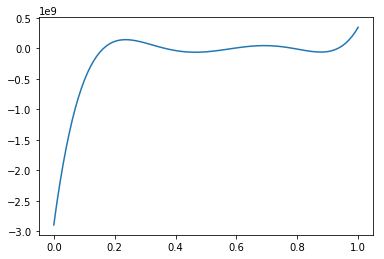

In [9]:
# load pandas
import pandas as pd
import polytools as pt
import numpy as np
import matplotlib.pyplot as plt

# data location
url='../data/InputParameters.txt'

# load data
dataframe=pd.read_csv(url,header=None,sep='\s+ ',engine='python')

# dataframe.head(2)
# dataframe[0].head(2)

n=dataframe.shape[0]
n

src=0
data=np.array(dataframe[src])
#H
mm=5
#out=moment(mm,v)
#out
k=-1
H=pt.Hankel(mm,data)   
#print("H=",H[0:6,0:6])
#print(np.linalg.det(H))
acfs=pt.aPCcfs(H,k)
print(acfs)
cfs=pt.PCcfs(H,k)
print(cfs)
#np.linalg.cond(H)
alpha, beta=pt.cmpAlphaBeta(H)
print("alpha:", alpha)
print("beta:",beta)
#J=JacobiMx(alpha,beta)
roots,weights=pt.cmpGrw(H)
print("Roots:", roots)
print("Weights:", weights)

c=np.flip(cfs,0)
p=np.poly1d(c)
rts=p.r
mms=H[0,:]
ws=pt.genGW(mms,rts)
print("p Roots:",rts)
print("p Weights:",ws)
eins=pt.np.ones(roots.shape[0])
np.dot(eins,weights)
np.dot(eins,ws)
ncf=pt.cmpNormCf(cfs,roots,weights)
#pt.uniHank(mm,0,1)
#pt.uniHank.__doc__
x=np.linspace(0,1,100)
plt.plot(x,p(x)/ncf)
plt.show()

In [ ]:
# load pandas
import pandas as pd
# load numpy
import numpy as np
import math

# data location
url='../data/InputParameters.txt'

# load data
dataframe=pd.read_csv(url,header=None,sep='\s+ ',engine='python')

# dataframe.head(2)
# dataframe[0].head(2)

n=dataframe.shape[0]
n

src=0
data=np.array(dataframe[src])
#v

def moment(mm, data):
    """computes mm-th raw moment"""
    return np.mean(data**mm)
    
def Hankel(mmx,data):
    """generates Hankel matrix"""
    H=np.zeros((mmx+1,mmx+1))
    for i in range(mmx+1):
        for j in range(i,mmx+1):
            H[i,j]=moment(i+j,data)
            H[j,i]=H[i,j]
    return H

def aPCcfs(H,k=-1,len=-1):
    """polynomial coefficients in increasing order, Sergey style"""
    l=H.shape[0]
    assert l>=len
    if len==-1:
        len=l
    cfs=np.zeros(len)
    if k<0:
        k=l-1
    elif k==0:
        cfs[0]=1
        return cfs
    assert k<l
    rH=H[0:k+1,0:k+1]
    rs=np.zeros(k+1)
    rs[-1]=1
    for j in range(k+1):
        rH[k,j]=0
    rH[k,k]=1
    cfs=np.linalg.solve(rH,rs)
    cfs.resize(len)
    return cfs
 
def PCcfs(H,k=-1,len=-1):
    """polynomial coefficientes in increasing order, Gautschi style via moment determinants (p. 53)"""
    l=H.shape[0]
    assert len<=l
    if len==-1:
        len=l
    cfs=np.zeros(len)
    if k<0:
        k=l-1
    elif k==0:
        cfs[0]=1
        return cfs
    assert k<l
    rH=H[0:k,0:k]
    idx=np.ones(l,dtype=bool)
    idx[k+1:l]=False
    delta=np.linalg.det(rH)
    for i in range(0,k):
        idx[i]=False
        Hk=H[0:k,idx]
        dHk=np.linalg.det(Hk)
        cfs[i]=(-1)**(k+i) * dHk/delta
        idx[i]=True
    cfs[k]=1
    return cfs

def cmpAlphaBeta(H,k=-1):
    """generates vectors of recursion coefficientes alpha and beta"""
    n=H.shape[0]
    if k==-1:
        k=n-1
    assert k<n  
    alpha=np.zeros(k)
    beta=np.zeros(k)
    delta=np.zeros(k+1)
    deltak=np.zeros(k+1)
    idx=np.zeros(n,dtype=bool)
    for l in range(1,k+1):
        #print(l)
        delta[l]=np.linalg.det(H[0:l,0:l])
        if l>1:
            idx[0:l-1]=True
            idx[l]=True
            deltak[l]=np.linalg.det(H[0:l,idx])
            idx[0:n]=False
    delta[0]=1
    deltak[0]=0
    deltak[1]=H[0,1]
    for l in range(k):
        if l>0:
            alpha[l]=deltak[l+1]/delta[l+1] - deltak[l]/delta[l]
            beta[l]=delta[l+1]*delta[l-1]/(delta[l]**2)
        else:
            alpha[l]=deltak[l+1]/delta[l+1]
            beta[l]=H[0,0]
    return alpha, beta

def JacobiMx(alpha,beta):
    """generates Jacobi Matrix"""
    n=alpha.shape[0]
    m=beta.shape[0]
    assert m==n
    J=np.diag(alpha)
    for l in range(n-1):
        J[l,l+1]=math.sqrt(beta[l+1])
        J[l+1,l]=J[l,l+1]
    return J

def cmpGrw(H,k=-1):
    """computes roots and weigth of the Gauss quadrature using Hankel Matrix, Gautschi p. 153"""
    n=H.shape[0]
    assert k<n
    alpha,beta=cmpAlphaBeta(H,k)
    J=JacobiMx(alpha,beta)
    print(J)
    tau, V=np.linalg.eig(J)
    roots=tau
    weights=beta[0]* (V[0,:]**2)
    #v=np.zeros(roots.shape[0])
    #for i in range(roots.shape[0]):
    #    v[i]=V[0,i]**2
    #weights=beta[0]*v  
    return roots,weights

def genGW(moments,roots):
    """computes Gaussian weights using moments and roots, compare with Karniadakis & Kirby p.236"""
    m=moments.shape[0]
    r=roots.shape[0]
    assert m>=r
    rs=moments[0:r]
    M=np.zeros([r,r])
    for i in range(r):
        for j in range(r):
            M[i,j]=roots[j]**i
    return np.linalg.solve(M,rs)
    
def cmpNormCf(cf,roots,weights):
    """computes the norming factor of the polynomial w.r.t. Gauss quadrature"""
    r=roots.shape[0]
    w=weights.shape[0]
    assert r==w
    c=np.flip(cfs,0)
    p=np.poly1d(c)
    nc=0;
    for i in range(r):
        nc+=(p(roots[i])**2)*weights[i]
    return math.sqrt(nc)
#H
mm=5
#out=moment(mm,v)
#out
k=-1
H=Hankel(mm,data)   
#print("H=",H[0:6,0:6])
#print(np.linalg.det(H))
acfs=aPCcfs(H,k)
print(acfs)
cfs=PCcfs(H,k)
print(cfs)
#np.linalg.cond(H)
alpha, beta=cmpAlphaBeta(H)
print("alpha:", alpha)
print("beta",beta)
#J=JacobiMx(alpha,beta)
roots,weights=cmpGrw(H)
print("Roots:", roots)
print("Weights:", weights)

c=np.flip(cfs,0)
p=np.poly1d(c)
rts=p.r
mms=H[0,:]
ws=genGW(mms,rts)
print("p Roots:",rts)
print("p Weights:",ws)
eins=np.ones(roots.shape[0])
np.dot(eins,weights)
np.dot(eins,ws)
cmpNormCf(cfs,roots,weights)

In [ ]:
import numpy as np

a=np.array([1,0,3])
c=np.flip(a,0)
np.polyval(c,5)
p=np.poly1d(c)
p(5)
p.c # show the coefficients
q=p**2 # square the polynomial p
q.c
q(5)
print(p)
p.r # roots
l=3
k=4
ar=np.arange(k)
A=np.array([ar, ar])
idx=np.ones(k,dtype=bool)
idx[0:0]=False
ar[idx]
A[0:2,idx]